#**Проект по Анализу Данных**
### Выполнил студент группы БЭК223 Амиров Марат

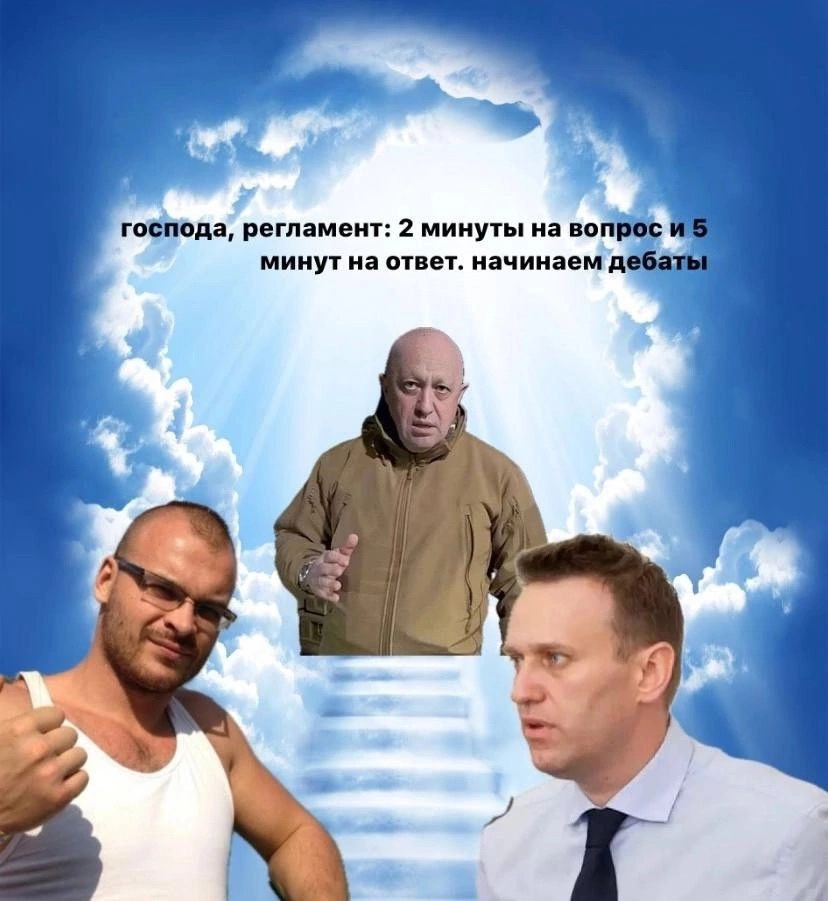

Позволю начать себе с совсем небольшого предисловия: изначально идея моего проекта была в проверке гипотезы, что посты со словами 'Путин', 'Президент' и тд. намного популярнее среднестатистического поста в государственных СМИ (на примере группы ВК 'РИА Новости'). Но потом я подумал, что строить предсказательную модель по таким параметрам будет тяжело и задачу поставлена слишком узко, поэтому я решил, что во время Eda мной будут рассмотрены топ-100 самых популярных имен собственных в постах (или слов с большой буквы), а во время пострения предсказательной модели мы рассмотрим влияние всех токенов с собственными именами на итоговую успешность поста.

# **Часть 1: Парсинг и получение данных**

Начнем, для начала мы подключимся к VK API и создадим сессию, используя ключ client_secret, который мне дал семинарист.



In [1]:
import vk_api
def auth_handler():
    key = input("Authentication code: ")
    return key, False
login = ''
password = ''
vk_session = vk_api.VkApi(login, password, auth_handler=auth_handler, app_id=6287487, client_secret="QbYic1K3lEV5kTGiqlq2")
vk_session.auth()
vk = vk_session.get_api()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 911.9 kB/s eta 0:00:00


После этого мы спарсим всю стену сообщества 'РИА новости', использую интрументы get_all и айди необходимой нам группы, который мы получили из веб-ссылки на сообщество. Думаю, что для создания репрезентативной выборки мне понадобится минимум 5000 постов, так как посты очень разные и по содрежанию и по их популярности.

In [2]:
tools = vk_api.VkTools(vk)
wall_id = -15755094
wall = tools.get_all('wall.get', 4, {'owner_id': wall_id}, limit = 5000)

На следующем этапе мы создадим Data Frame с нашими данными, для каждого поста нам понадобятся: количество лайков, просмотров, репостов, комментариев и его текст. Думаю, этих данных, как ключевых, будет достаточно. Также уберем посты с пустым текстовым полем и посты, в которых в тексте присутствуют только эмодзи (в нашем случае - молнии). Два поста (45432794 и 44731519) пришлось убрать вручную, так как при их парсинге воpникали непредвиденные ошибки. Столбец с датой переведем из экспоненицального формата в обычный, выведем медиану и среднее для количества лайков.

In [3]:
import pandas as pd
df = pd.DataFrame()
df.index = [post['id'] for post in wall['items']]
df['date'] = [post['date'] for post in wall['items']]
df['date'] = pd.to_datetime(df['date'], unit='s')
df['date'] = df['date'].dt.date
col = ['likes', 'reposts', 'comments', 'views']
for c in col:
  df[c] = [post[c]['count'] for post in wall['items']]
df['text'] = [post['text'] for post in wall['items']]
df = df.loc[df['text'] != '⚡⚡⚡']
df = df.loc[df['text'] != '']
df=df.dropna()
df = df.drop(index=45432794)
df = df.drop(index=44731519)
df['likes'].median(), df['likes'].mean()


(326.0, 552.9885892116182)

In [4]:
df

,date,likes,reposts,comments,views,text
45629937,2024-06-02,33,2,2,5430,"Подполье сообщило об атаке по винзаводу ""Оливи..."
45629743,2024-06-02,51,7,82,20773,"США, Япония и Южная Корея летом проведут первы..."
45629605,2024-06-02,219,4,28,32002,Сотрудники Росгвардии поздравили с Днём защиты...
45629099,2024-06-02,84,12,34,46542,Поселение Радонеж посещают не только православ...
45628861,2024-06-02,167,24,201,63790,Байден понимает все последствия своего решения...
...,...,...,...,...,...,...
44683457,2024-01-25,127,28,111,56769,Эрдоган официально утвердил членство Швеции в ...
44683183,2024-01-25,380,48,34,64284,В городе Северск Томской области Росатом прист...
44682909,2024-01-25,254,20,145,87252,СК опубликовал первые результаты расследования...
44682624,2024-01-25,249,35,112,100151,ВСУ сбили Ил-76 в Белгородской области из ЗРК ...


# **Часть 2: Создание целевой переменной, дополнительных признаков и предобработка**

Создадим две новые переменные: активность и популярность, которые показывают, какой процент людей лайкнул пост, который просмотрел и на сколько сильно каждый пост отличается от медианы по лайкам (будет принимать, что если пост популярнее половины всех постов, то он 'Популярен'). Столбцы 'reposts' и 'comments' оставим без изменений, думаю, что в будущем мы будем обучать несколько регрессий и будем добавлять эти признаки (предварительно обработав), смотря как изменилось точность нашего прогноза.

In [5]:
df['Popularity'] = df['likes']/df['likes'].median()
df['Activity'] = df['likes']/df['views']

Давайте перейдем к созданию нашего таргета: отнормируем столбцы 'Popularity' и 'Activity' и создадим столбец с их суммой, делая ставку на то, что для новостного издания важно, чтобы пост был одинаково и популярен и при этом чтобы аудитория на нем была достаточно активной.


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Popularity', 'Activity']] = scaler.fit_transform(df[['Popularity', 'Activity']])
df['Success_Rate'] = df['Popularity']+df['Activity']
df.head()

,date,likes,reposts,comments,views,text,Popularity,Activity,Success_Rate
45629937,2024-06-02,33,2,2,5430,"Подполье сообщило об атаке по винзаводу ""Оливи...",-0.541643,0.267692,-0.273951
45629743,2024-06-02,51,7,82,20773,"США, Япония и Южная Корея летом проведут первы...",-0.522893,-0.709514,-1.232407
45629605,2024-06-02,219,4,28,32002,Сотрудники Росгвардии поздравили с Днём защиты...,-0.347897,0.474336,0.126439
45629099,2024-06-02,84,12,34,46542,Поселение Радонеж посещают не только православ...,-0.488519,-0.884948,-1.373467
45628861,2024-06-02,167,24,201,63790,Байден понимает все последствия своего решения...,-0.402062,-0.665579,-1.067641


Присвоим таргету категориальные значения: пост успешный (1), если его таргет больше 1, он обычный (0), если его таргет от -1 до 1 и он непопулярный если таргет меньше -1. Проверим сбалансированность классов и увидим, что большинство постов - обычные, а непопулярных постов в два раза больше, чем популярных, что в целом, логично. Кстати, думаю очевидно, но скажу, что все остальные признаки кроме 'text' и 'target' являются числовыми.


In [7]:
df['Target'] = df['Success_Rate'].apply(lambda x: -1 if x < -1 else (1 if x > 1 else 0))
df['Target'].value_counts()


Target
 0    2090
-1    1109
 1     657
Name: count, dtype: int64

Далее напишем функцию custom_tokenizer, которая будет обрабатывать текст и выдавать список имен собственных приведенных к основной части слова (без приставок и сууффиксов). Опишу процесс его работы:
1. Делим текст, удаля стоп-слова и пунктуацию.
2. Удаляем все эмодзи и оставляем только токены, которые начинаются с большой буквы.
3. Применяем SnowBallStemmer для обрезки слов до основных частей.
4. Убираем токен 'росс', потому что он является выбросом, так как слово Россия встречается почти в каждом посте.

Ниже пример его работы.

In [8]:
import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
punctuation = list(string.punctuation)
nltk.download('stopwords')
stop_words = stopwords.words('russian')

def custom_tokenizer(text):
  vectorizer = CountVectorizer(lowercase=False, stop_words=stop_words+punctuation)
  X_train_counts = vectorizer.fit_transform([text])
  vocaby = vectorizer.get_feature_names_out()
  token_counts = np.array(X_train_counts.sum(axis=0)).ravel()
  filtered_vocab = []
  filtered_token_counts = []
  tokensy=[]
  tokensy1=[]
  for idx, token in enumerate(vocaby):
      if not (len(token)==1 and ord(token) >= 128) and not (token.isalpha()==True and token.lower() in stop_words) and token[0].isupper()==True:
          filtered_vocab.append(token)
          filtered_token_counts.append(token_counts[idx])
  filtered_token_counts = np.array(filtered_token_counts)
  sorted_indices_descending = np.argsort(filtered_token_counts)[::-1]
  for idx in sorted_indices_descending:
    tokensy.append(filtered_vocab[idx])
  tokensy = [stemmer.stem(w) for w in tokensy]
  for t in tokensy:
    if t!='росс':
      tokensy1.append(t)
  return tokensy1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Вот пример выполнения:

In [9]:
df['text'].iloc[0]

'Подполье сообщило об атаке по винзаводу "Оливия" под Николаевом, где базировались ВСУ. Об этом сообщил координатор Сергей Лебедев. \n \nВо время ударов работала украинская ПВО. Предположительно, немецкая ЗСУ "Гепард". \n \nПосле взрыва быстро приехали машины скорой помощи и представители СБУ. Начался обход и досмотр местных жителей.'

In [10]:
df['Tokens']=df['text'].apply(custom_tokenizer)
custom_tokenizer(df['text'].iloc[0])


['серг',
 'сбу',
 'предположительн',
 'подпол',
 'пво',
 'олив',
 'николаев',
 'нача',
 'лебед',
 'зсу',
 'гепард',
 'всу']

# **Часть 3: Визуализация и EDA**

Теперь выведем топ-100 самых популярных имен собственных по количеству встреч по всей странице. Заметим, что самыми популярными именами собственными являются сокращения от названий других стран, но будет ли это говорить об их связи с таргетом? Чуть позже узнаем.

In [11]:
cv = CountVectorizer(tokenizer=custom_tokenizer, lowercase=False)
X = cv.fit_transform(df['text'])
vocab = cv.get_feature_names_out()
token_counts = np.array(X.sum(axis=0)).ravel()
sorted_indices_descending = np.argsort(token_counts)[::-1]
top_tokens_descending = [(vocab[idx], token_counts[idx]) for idx in sorted_indices_descending[:100]]
for token, count in top_tokens_descending:
    print(f"{token}: {count}")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


украин: 639
сша: 374
путин: 352
всу: 303
москв: 280
владимир: 217
ри: 200
новост: 198
эт: 184
киев: 179
российск: 171
мид: 147
крокус: 146
запад: 136
нат: 133
зеленск: 128
прямаятрансляц: 122
вашингтон: 115
такж: 115
сво: 113
миноборон: 100
ес: 98
европ: 90
израил: 89
александр: 83
герман: 82
сми: 78
президент: 78
байд: 76
сегодн: 74
серг: 70
франц: 69
кром: 66
мчс: 64
украинск: 63
дмитр: 60
пво: 60
глав: 59
госдум: 59
евросоюз: 59
днр: 57
побед: 57
польш: 56
однак: 55
ки: 54
крым: 54
оон: 53
международн: 53
молдав: 51
нов: 51
макрон: 50
белгородск: 50
авдеевк: 49
карлсон: 48
сит: 48
бел: 47
петербург: 47
захаров: 46
так: 46
жител: 45
кита: 45
пентагон: 44
холл: 44
великобритан: 44
подробн: 43
газ: 43
венгр: 42
мвд: 42
париж: 41
суд: 40
запорожск: 40
бпла: 39
харьковск: 39
Times: 38
реч: 38
песк: 38
фсб: 38
цик: 38
белгород: 37
антон: 36
велик: 36
трамп: 36
совет: 36
мужчин: 36
брюссел: 36
турц: 36
такер: 35
белорусс: 35
американск: 35
отечествен: 34
московск: 34
воен: 34
ск: 33
ира: 3

Выведем попарный график и увидим, что сильных связей на нем не наблюдается, кроме тех, которые мы сами и сделали во время создания целевой переменной. Интересно, что зависимость между популярностью и таргетом более пологая, чем зависимость между таргетом и активностью, это значит, что многие посты становятся успешнее за счет высокой популярности, но не активности.

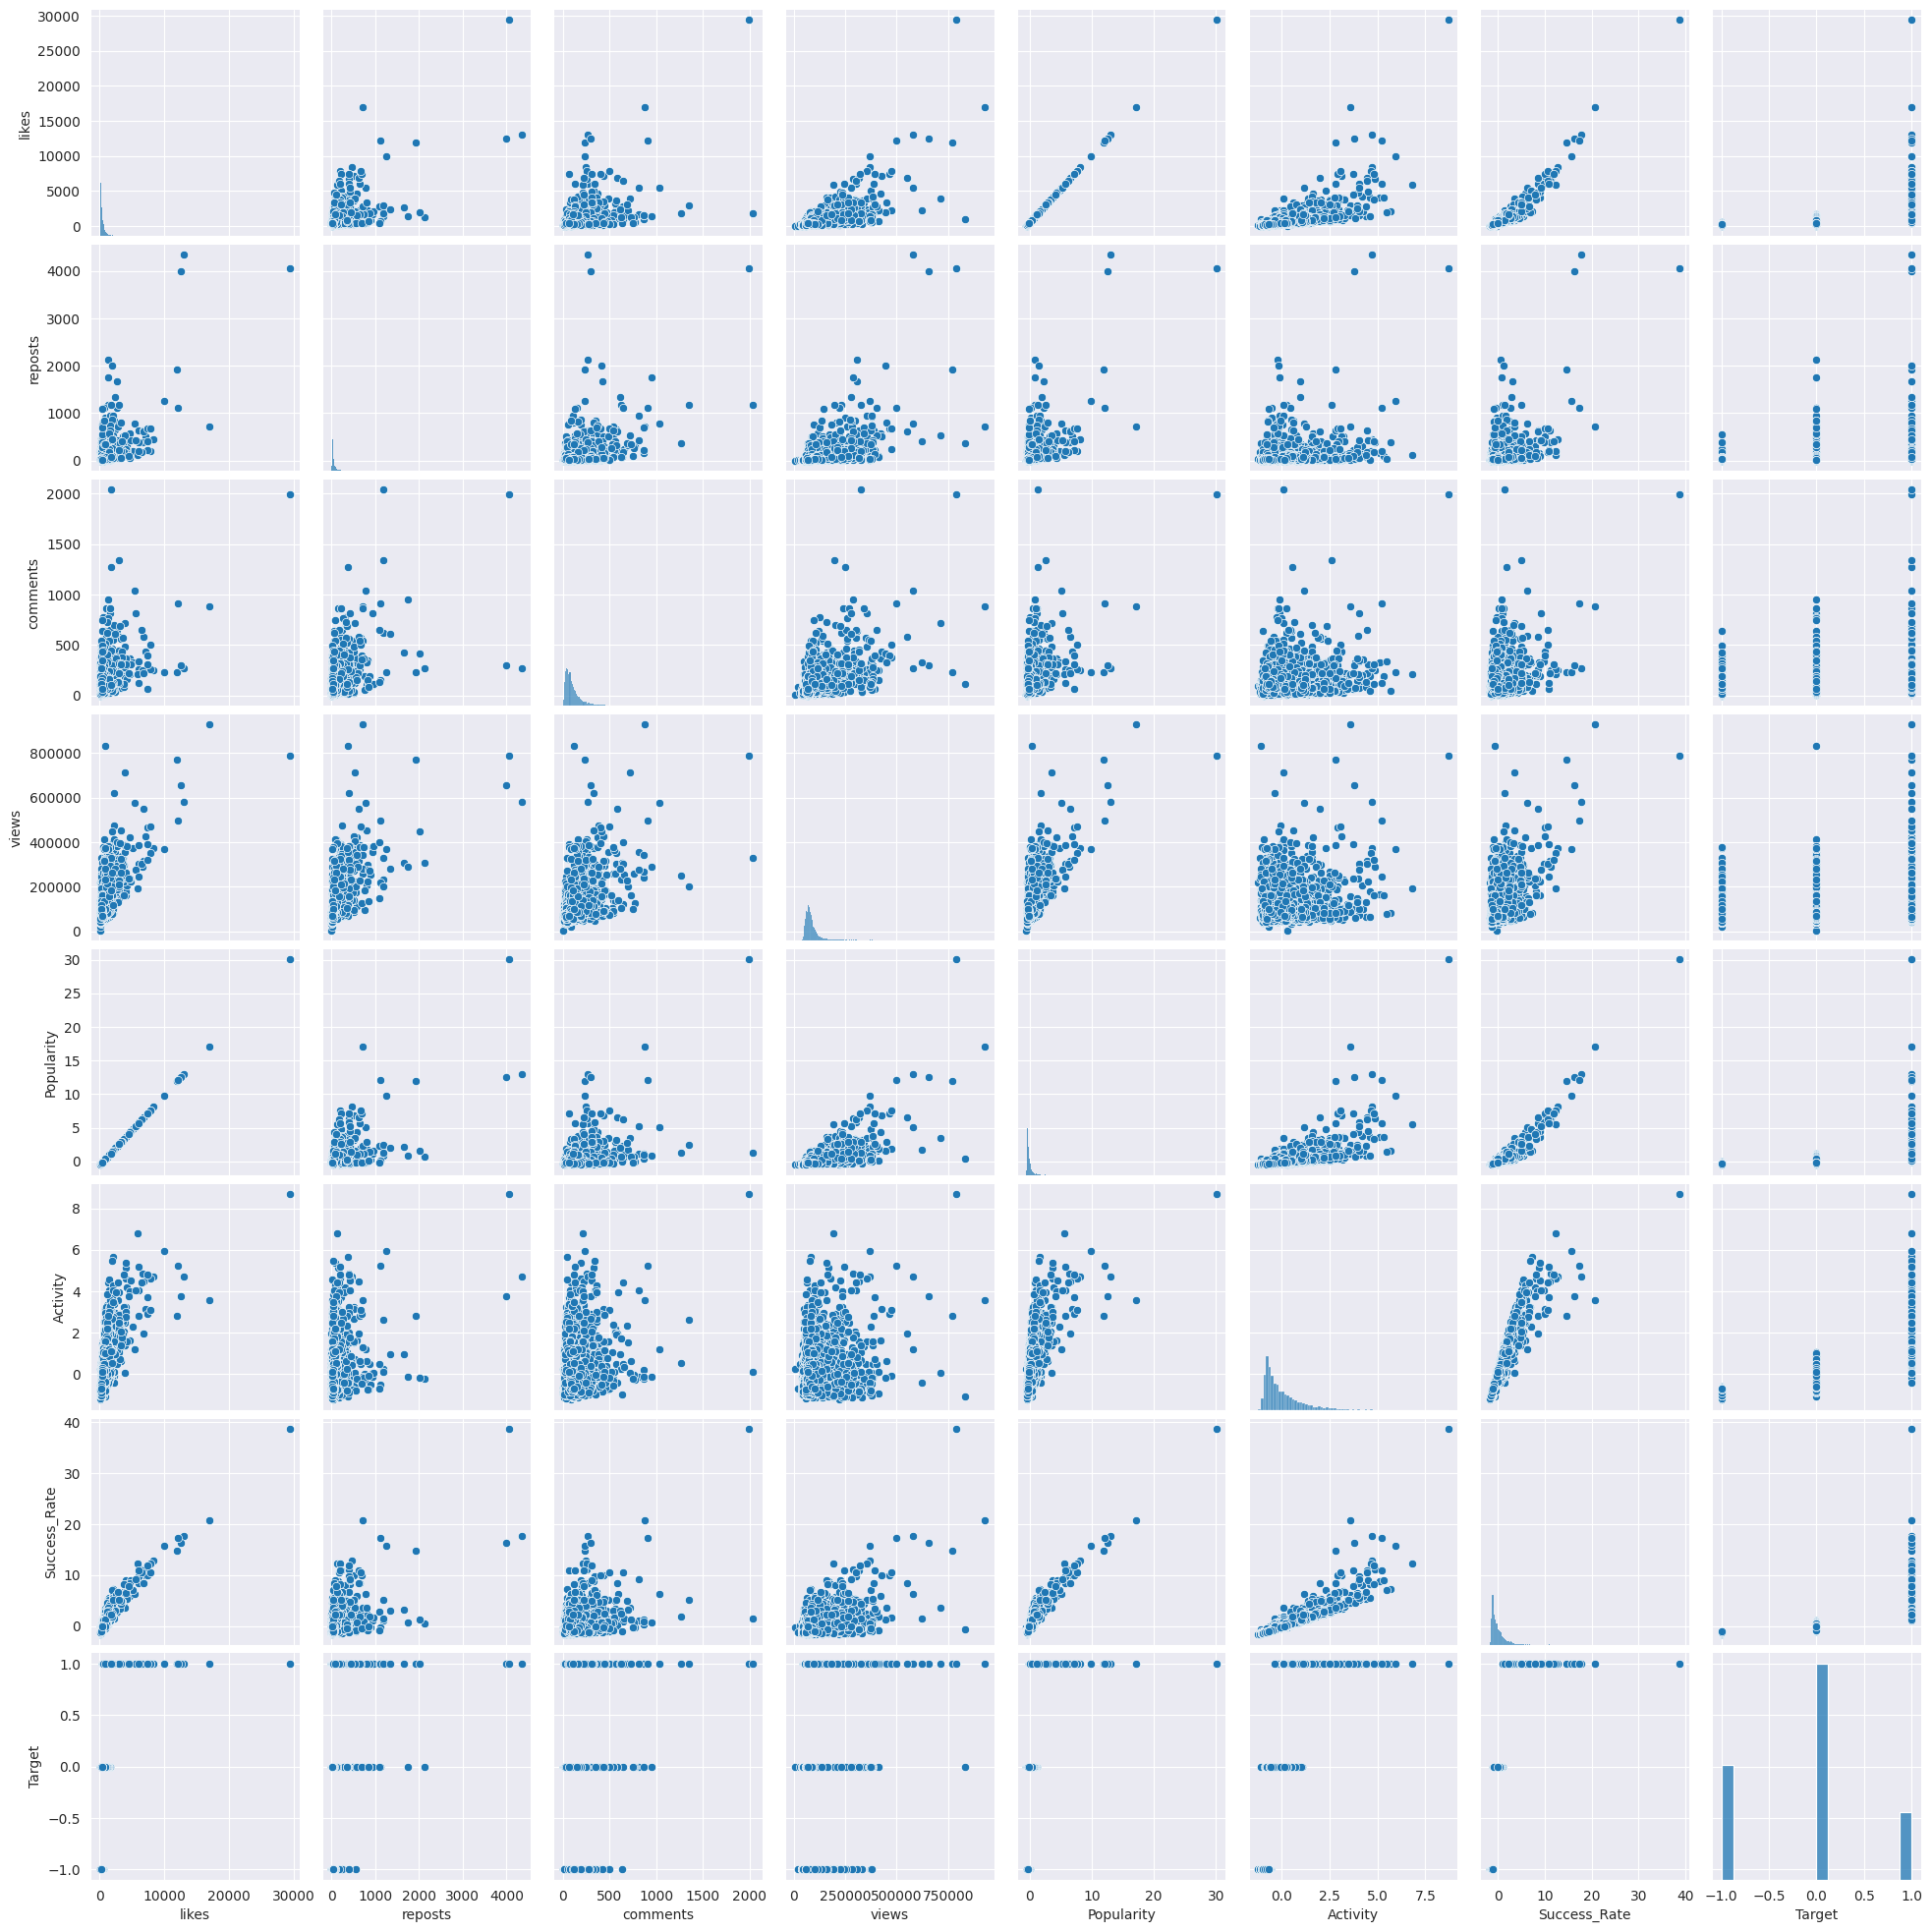

In [12]:
import seaborn as sns
sns.set_style("darkgrid")
sns.pairplot(df);

Теперь было бы интересно посмотреть, сколько в среднем лайков приходится на каждый токен из топ-100. Для этого мы собираем сумму лайков для каждого токена и количество его упоминаний, а затем считаем среднее. Оказалось, что лидирует интересный токен -  'мужчин', что же это значит? На самом деле ничего, просто новости зачастую начинаются с этого слова и несут информацию либо сугубо отрицательного характера (Мужчина убил 500 детей) или положительного (Мужчину наградили звездой почета), что делает эти посты популярнее.

P.S. Из интереса я проверил популярность токена 'женщин', оказалось, что он включается чуть меньшее количество раз, но очень редко начинается с большой буквы, что исключает его из списка наших токенов.

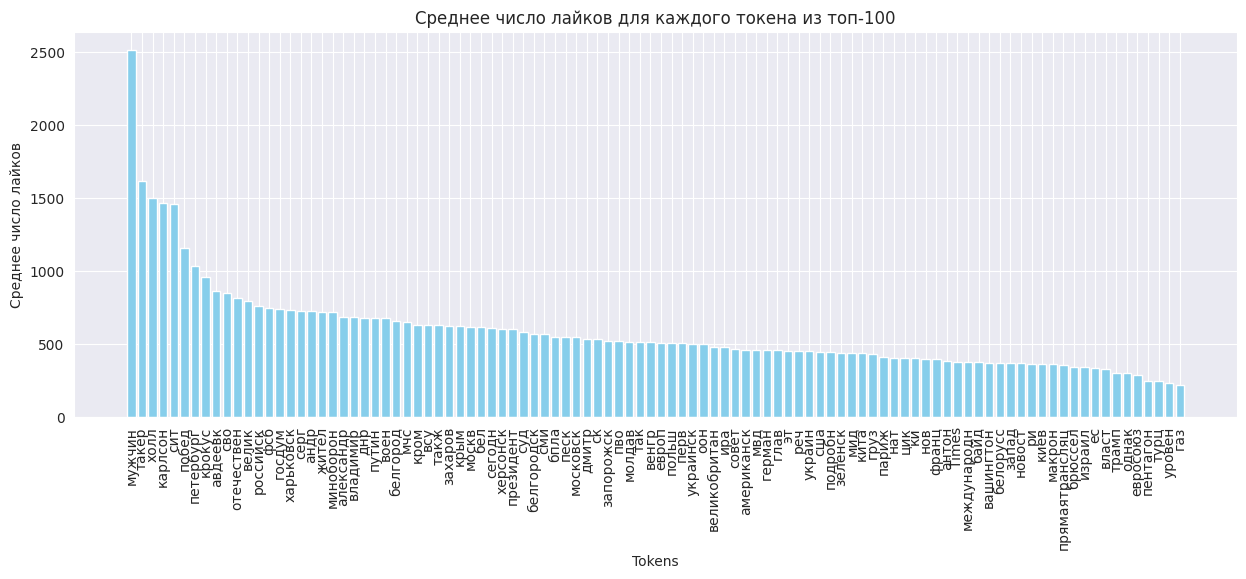

In [13]:
import matplotlib.pyplot as plt
names100=[]
for i in top_tokens_descending:
  names100.append(i[0])
likes_sum = {token: 0 for token in names100}
counts = {token: 0 for token in names100}
for index, row in df.iterrows():
    tokens = row['Tokens']
    for token in tokens:
        if token in names100:
            likes_sum[token] += row['likes']
            counts[token] += 1
average_likes = {token: (likes_sum[token] / counts[token]) for token in names100}
sorted_tokens = sorted(average_likes, key=average_likes.get, reverse=True)
sorted_likes = [average_likes[token] for token in sorted_tokens]

plt.figure(figsize=(15, 5))
plt.bar(sorted_tokens, sorted_likes, color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Среднее число лайков')
plt.title('Среднее число лайков для каждого токена из топ-100')
plt.xticks(rotation=90)
plt.show()

Далее было бы интересно посмотреть на то, как инфоповоды влияют и на количество лайков по токенам и сколько в среднем каждый инфоповод удерживает лидерство, для этого мы можем посчитать самые 'залайканные' токены с начала нашего года по неделям. Видно, что наибольшую активность люди проявляли в марте, во время трагедии в 'Крокусе', второй по популярности инфоповод - праздник 9 мая, во все остальные недели самым популярным токеном были 'путин', 'украин' и 'сша'. Еще можно заметить, что каждый из токенов не держал лидерство более двух недель. Ниже продублирован график самого популярного токена из топ-100 для каждого дня.

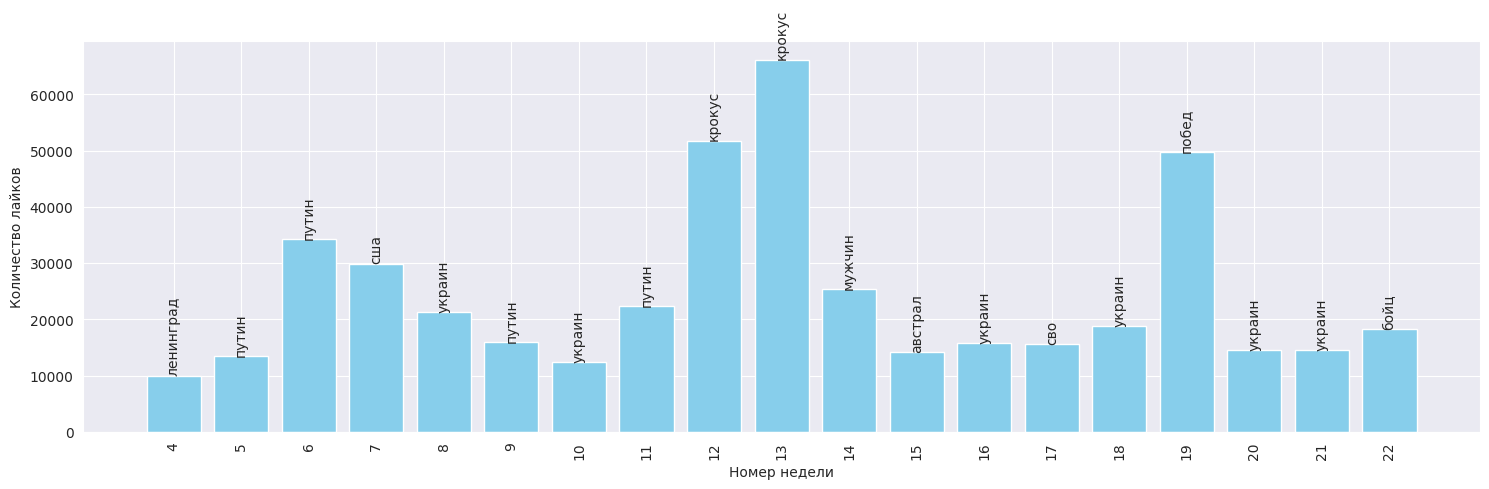

In [14]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.isocalendar().week

weekly_token_likes = df.explode('Tokens').groupby(['week', 'Tokens'])['likes'].sum().reset_index()
most_liked_tokens = weekly_token_likes.loc[weekly_token_likes.groupby('week')['likes'].idxmax()]

plt.figure(figsize=(15, 5))
bars = plt.bar(x=most_liked_tokens['week'].astype(str), height=most_liked_tokens['likes'], color='skyblue')
for bar, token in zip(bars, most_liked_tokens['Tokens']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, token, ha='center', va='bottom', rotation=90)

plt.xlabel('Номер недели')
plt.ylabel('Количество лайков')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

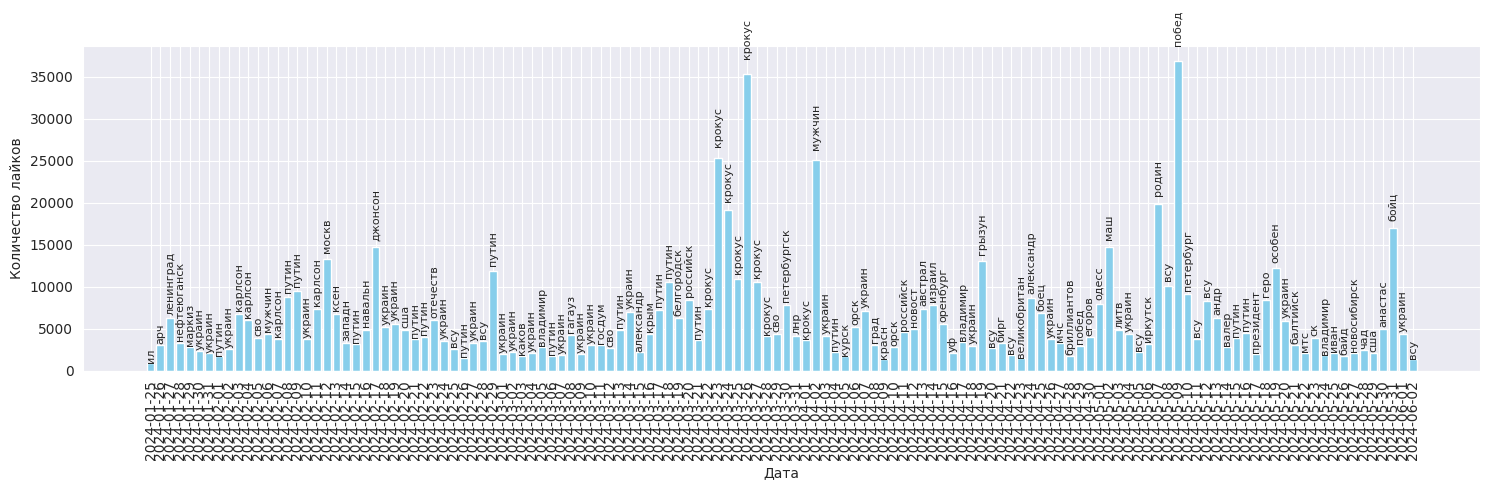

In [15]:
df['date'] = pd.to_datetime(df['date'])
daily_token_likes = df.explode('Tokens').groupby(['date', 'Tokens'])['likes'].sum().reset_index()
most_liked_tokens_daily = daily_token_likes.loc[daily_token_likes.groupby('date')['likes'].idxmax()]
plt.figure(figsize=(15, 5))
bars = plt.bar(x=most_liked_tokens_daily['date'].dt.strftime('%Y-%m-%d'), height=most_liked_tokens_daily['likes'], color='skyblue')
for bar, token in zip(bars, most_liked_tokens_daily['Tokens']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * yval, token, ha='center', va='bottom', rotation=90, fontsize=8)
plt.xlabel('Дата')
plt.ylabel('Количество лайков')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

А теперь посмотрим на то, какое среднее значение таргета наблюдается для каждого из топ-100 токенов. Видно, что для большинства из них оно по модулю меньше 0.4, но есть токены, которые чаще встречаются в успешных постах, такие как 'такер', 'сво', 'путин', 'отечественн'. А есть безуспешные токены: 'израил', 'турц', 'газ', 'уровен'. Интересено, что почти все названия иностранных государств тут находятся в отрицательной зоне.

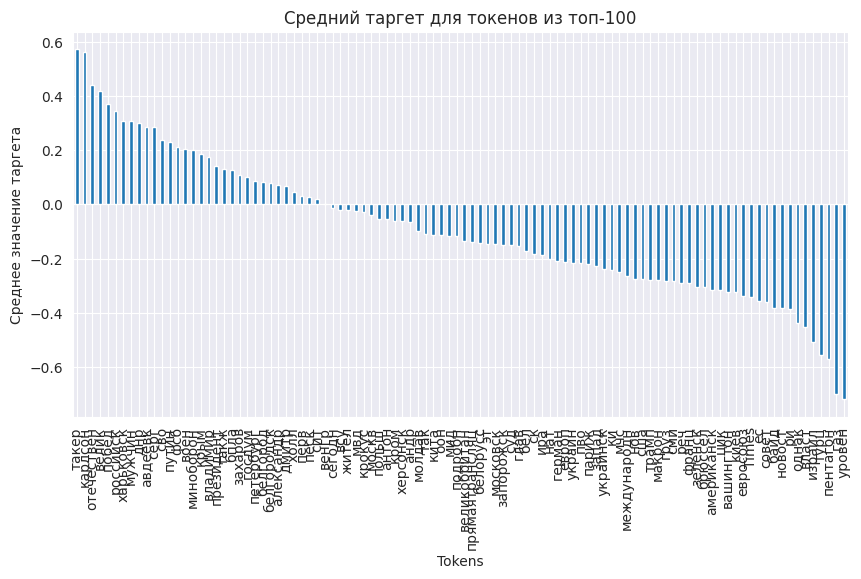

In [16]:
exploded_df = df.explode('Tokens')
filtered_df = exploded_df[exploded_df['Tokens'].isin(names100)]
average_likes = filtered_df.groupby('Tokens')['Target'].mean()
average_likes.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.xlabel('Tokens')
plt.ylabel('Среднее значение таргета')
plt.title('Средний таргет для токенов из топ-100')
plt.show()

Я думаю, что после проведенного анализа оптимальной моделью для вынесения предсказаний является логистическая регрессия, построением которой я и буду заниматься. Из интересного, думаю, что во время построения модели я буду смотреть на то, какие токены сильнее влияют на популярность и что-то мне подсказывает, что токены с более высоким/низким средним значением таргета будут иметь больший по модулю вес в регрессии.

#**Часть 4: Проверка Гипотез**

В EDA нам было интересно посмотреть на абсолютное значение количества лайков, репостов и тд, здесь жы мы наконец-то можем отскалировать для проверки наших дальнейших гипотез.

In [17]:
df_new=df.copy()
scaler = StandardScaler()
df_new[['likes', 'reposts', 'comments',  'views']] = scaler.fit_transform(df_new[['likes', 'reposts', 'comments',  'views']])
df_new.head()

,date,likes,reposts,comments,views,text,Popularity,Activity,Success_Rate,Target,Tokens,week
45629937,2024-06-02,-0.541643,-0.361603,-0.953406,-1.442541,"Подполье сообщило об атаке по винзаводу ""Оливи...",-0.541643,0.267692,-0.273951,0,"[серг, сбу, предположительн, подпол, пво, олив...",22
45629743,2024-06-02,-0.522893,-0.332277,-0.251658,-1.202561,"США, Япония и Южная Корея летом проведут первы...",-0.522893,-0.709514,-1.232407,-1,"[япон, южн, сша, ренхап, коре, конкретн, Freed...",22
45629605,2024-06-02,-0.347897,-0.349872,-0.725338,-1.026929,Сотрудники Росгвардии поздравили с Днём защиты...,-0.347897,0.474336,0.126439,0,"[сотрудник, росгвард, днем, геническ, влад]",22
45629099,2024-06-02,-0.488519,-0.302951,-0.672707,-0.799509,Поселение Радонеж посещают не только православ...,-0.488519,-0.884948,-1.373467,-1,"[серг, радонеж, поселен, ежегодн, дел]",22
45628861,2024-06-02,-0.402062,-0.232568,0.792191,-0.529733,Байден понимает все последствия своего решения...,-0.402062,-0.665579,-1.067641,-1,"[сша, харьковск, он, кирб, вашингтон, всу, бел...",22


**Первая гипотеза**

Проверим, правда ли популярность постов, выраженная в лайках, значительно влияет на рейтинг Success Rate.

Нулевая гипотеза (H0): Нет значимой разницы в количестве лайков между новостями с положительным и отрицательным значением Success_Rate.

Альтернативная гипотеза (H1): Существует значимая разница в количестве лайков между новостями с положительным и отрицательным значением Success_Rate.

В ходе своих рассуждений я понял, что все данные в моем датасете распределены не нормально и подлежат проверке  через тест Манна-Уитни. Но так как изначально я этого не знал, я везде добавил условие, что если выборка распределена нормально, то тестирование будет происходить с помощью t теста. Проверку на нормальность я произвожу с помощью коэффициента Шапиро.

In [18]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

positive_success_rate = df_new[df_new['Success_Rate'] > 0]['likes']
negative_success_rate = df_new[df_new['Success_Rate'] < 0]['likes']

stat_pos, p_pos = shapiro(positive_success_rate)
stat_neg, p_neg = shapiro(negative_success_rate)

print(f"Shapiro-Wilk Test for positive Success_Rate likes: Stat={stat_pos}, p-value={p_pos}")
print(f"Shapiro-Wilk Test for negative Success_Rate likes: Stat={stat_neg}, p-value={p_neg}")

alpha = 0.05
if p_pos > alpha and p_neg > alpha:
    print("Данные нормально распределены. Используем t-тест.")
    t_stat, p_value = ttest_ind(positive_success_rate, negative_success_rate)
else:
    print("Данные не нормально распределены. Используем тест Манна-Уитни.")
    stat, p_value = mannwhitneyu(positive_success_rate, negative_success_rate)

print(f"Test statistic: {stat}, P-value: {p_value}")

if p_value < alpha:
    print("Мы отвергаем нулевую гипотезу (существует значимая разница в количестве лайков).")
else:
    print("Мы не можем отвергнуть нулевую гипотезу (нет значимой разницы в количестве лайков).")

Shapiro-Wilk Test for positive Success_Rate likes: Stat=0.40288054943084717, p-value=0.0
Shapiro-Wilk Test for negative Success_Rate likes: Stat=0.8947931528091431, p-value=1.1748023896406039e-38
Данные не нормально распределены. Используем тест Манна-Уитни.
Test statistic: 3246260.0, P-value: 0.0
Мы отвергаем нулевую гипотезу (существует значимая разница в количестве лайков).


**Вторая гипотеза**

Во время EDA мы поняли, что в 2024 году было два самых масштабных инофоповода: трагедия в Крокус-Сити Холле и интервью В.В.Путина Такеру Карлсону. Проверим, правда ли количество комментариев под постами с токенами 'такер' и 'холл' примерно одинаково.

Нулевая гипотеза (H0): Нет значимой разницы в количестве комментариев под постами, содержащими токены 'холл' и 'такер'.

Альтернативная гипотеза (H1): Существует значимая разницы в количестве комментариев под постами, содержащими токены 'холл' и 'такер'.

In [19]:
df_new['contains_taker'] = df_new['Tokens'].apply(lambda x: 'такер' in x)
df_new['contains_holl'] = df_new['Tokens'].apply(lambda x: 'холл' in x)

comments_with_taker = df_new[df_new['contains_taker']]['comments']
comments_with_holl = df_new[df_new['contains_holl']]['comments']

stat_with, p_with = shapiro(comments_with_taker)
stat_without, p_without = shapiro(comments_with_holl)

print(f"Shapiro-Wilk Test for comments with Ukraine: Stat={stat_with}, p-value={p_with}")
print(f"Shapiro-Wilk Test for comments without Ukraine: Stat={stat_without}, p-value={p_without}")

if p_with > alpha and p_without > alpha:
    print("Данные нормально распределены. Используем t-тест.")
    t_stat, p_value = ttest_ind(comments_with_taker, comments_with_holl)
else:
    print("Данные не нормально распределены. Используем тест Манна-Уитни.")
    stat, p_value = mannwhitneyu(comments_with_taker, comments_with_holl)

print(f"Test statistic: {stat}, P-value: {p_value}")

if p_value < alpha:
    print("Мы отвергаем нулевую гипотезу (существует значимая разница в количестве комментариев).")
else:
    print("Мы не отверагем нулевую гипотезу (нет значимой разницы в количестве комментариев)")

Shapiro-Wilk Test for comments with Ukraine: Stat=0.6485527753829956, p-value=8.73011529733958e-08
Shapiro-Wilk Test for comments without Ukraine: Stat=0.3920104503631592, p-value=4.011865926273339e-12
Данные не нормально распределены. Используем тест Манна-Уитни.
Test statistic: 842.0, P-value: 0.25696169226818044
Мы не отверагем нулевую гипотезу (нет значимой разницы в количестве комментариев)


**Третья гипотеза**

Перейдем к апогею внедрения shizo-тестирования там, где это почти невозможно, посмотрев на pairplot, построенный во время EDA анализа, я заметил, что зависимость Success Rate от популярности менее пологая, чем от активности, что говорит нам о том, что влияние популярности на общую успешность поста более высокое, чем такое же влияние активности. Проверим же это для каждого значения Target. Использовать будем тест Вилкоксона, потому что наши переменные зависимы через столбец likes.

Нулевая гипотеза (H0): Нет значимой разницы между переменными Popularity и Activity, когда речь заходит об их сравнении.

Альтернативная гипотеза (H1): Существует значимая разница между переменными Popularity и Activity, когда речь заходит об их сравнении.

In [20]:
from scipy.stats import shapiro, ttest_rel, wilcoxon
targets = df_new['Target'].unique()

results = []

for target in targets:
    group = df_new[df_new['Target'] == target]
    popularity = group['Popularity']
    activity = group['Activity']
    stat_pop, p_pop = shapiro(popularity)
    stat_act, p_act = shapiro(activity)

    print(f"Target={target}")
    print(f"Shapiro-Wilk Test for Popularity: Stat={stat_pop}, p-value={p_pop}")
    print(f"Shapiro-Wilk Test for Activity: Stat={stat_act}, p-value={p_act}")
    alpha = 0.05
    if p_pop > alpha and p_act > alpha:
        print("Данные нормально распределены. Используем парный t-тест.")
        t_stat, p_value = ttest_rel(popularity, activity)
    else:
        print("Данные не нормально распределены. Используем парный тест Вилкоксона.")
        t_stat, p_value = wilcoxon(popularity, activity)

    print(f"Test statistic: {t_stat}, P-value: {p_value}")

    results.append((target, t_stat, p_value))

    if p_value < alpha:
        print("Мы отвергаем нулевую гипотезу (существует значимая разница между популярностью и активностью).")
    else:
        print("Мы не можем отвергнуть нулевую гипотезу (нет значимой разницы между популярностью и активностью).")
    print()

results_df = pd.DataFrame(results, columns=['Target', 'Test Statistic', 'P-value'])
print(results_df)

Target=0
Shapiro-Wilk Test for Popularity: Stat=0.858407735824585, p-value=7.860079268182904e-40
Shapiro-Wilk Test for Activity: Stat=0.945573627948761, p-value=4.101000497496338e-27
Данные не нормально распределены. Используем парный тест Вилкоксона.
Test statistic: 1027051.0, P-value: 0.01760886109893102
Мы отвергаем нулевую гипотезу (существует значимая разница между популярностью и активностью).

Target=-1
Shapiro-Wilk Test for Popularity: Stat=0.9255173802375793, p-value=5.2151105350399853e-23
Shapiro-Wilk Test for Activity: Stat=0.9850584864616394, p-value=3.071140897148439e-09
Данные не нормально распределены. Используем парный тест Вилкоксона.
Test statistic: 0.0, P-value: 5.593894727849199e-183
Мы отвергаем нулевую гипотезу (существует значимая разница между популярностью и активностью).

Target=1
Shapiro-Wilk Test for Popularity: Stat=0.45512664318084717, p-value=1.5310587021212951e-40
Shapiro-Wilk Test for Activity: Stat=0.8833922743797302, p-value=8.018971787785873e-22
Данн

Как можно заметить, значимая разница и в правду существует, скорее всего популярность принимает больше положительных по модулю значений, что и увеличивает ее влияние на таргет.

#**Часть 5: Машинное обучение**


Для начала уберем все признаки, которые бы влияли на наш таргет напрямую, а также бесполезные признаки. У нас осталось так мало столбцов, что же делать? Правильно, закодировать все токены в 5000+ столбцов.

In [23]:
df_ml=df_new.drop(['date','likes', 'views', 'text', 'Popularity', 'Activity', 'Success_Rate', 'week', 'contains_taker', 'contains_holl'], axis=1)
df_ml.head()

,reposts,comments,Target,Tokens
45629937,-0.361603,-0.953406,0,"[серг, сбу, предположительн, подпол, пво, олив..."
45629743,-0.332277,-0.251658,-1,"[япон, южн, сша, ренхап, коре, конкретн, Freed..."
45629605,-0.349872,-0.725338,0,"[сотрудник, росгвард, днем, геническ, влад]"
45629099,-0.302951,-0.672707,-1,"[серг, радонеж, поселен, ежегодн, дел]"
45628861,-0.232568,0.792191,-1,"[сша, харьковск, он, кирб, вашингтон, всу, бел..."


In [24]:
df_ml['Tokens'] = df_ml['Tokens'].apply(lambda x: list(set(x)))
tokens_dummies = df_ml['Tokens'].apply(lambda x: pd.Series(1, index=x)).fillna(0)
data_expanded = pd.DataFrame(pd.concat([df_ml.drop('Tokens', axis=1), tokens_dummies], axis=1))
data_expanded

,reposts,comments,Target,сбу,лебед,пво,подпол,предположительн,зсу,николаев,...,западник,архив,ловк,MI6,орлеан,Resmi,Gazete,брест,од,Info
45629937,-0.361603,-0.953406,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45629743,-0.332277,-0.251658,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45629605,-0.349872,-0.725338,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45629099,-0.302951,-0.672707,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45628861,-0.232568,0.792191,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44683457,-0.209108,0.002725,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
44683183,-0.091803,-0.672707,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
44682909,-0.256029,0.300968,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44682624,-0.168051,0.011497,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Теперь разделим нашу выборку на обучающую и тестовую и обучем логистическую регрессию с тремя признаками (отнормировав все признаки через конвеер, на всякий случай).

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_expanded.drop('Target', axis=1), data_expanded['Target'], test_size=0.3)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
predictions=pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.43      0.50      0.46       332
           0       0.60      0.56      0.58       616
           1       0.46      0.42      0.44       209

    accuracy                           0.52      1157
   macro avg       0.50      0.49      0.49      1157
weighted avg       0.52      0.52      0.52      1157



Видно, что наша модель имеет accuracy = 52%. Что в целом неплохой результат, относительно того, какой набор признаков мы имеем. Случайный классификатор давал бы accuracy = 33%, так что...  Можно еще взглянуть на коэффициенты нашей модели (их целых 3 набора, для предсказания вероятности для каждого класса).

In [30]:
model = pipeline.named_steps['logisticregression']

print("Коэффициенты модели:")
print(model.coef_)

print("Интерсепты модели:")
print(model.intercept_)

Коэффициенты модели:
[[-8.77637728e-01 -6.64932514e-01  1.79538261e-02 ... -6.57084024e-04
  -6.57084024e-04  1.05224628e-01]
 [ 1.86536304e-01 -1.30897794e-01  8.31160409e-03 ...  9.11903555e-04
   9.11903555e-04 -7.80539810e-02]
 [ 6.91101424e-01  7.95830308e-01 -2.62654302e-02 ... -2.54819532e-04
  -2.54819532e-04 -2.71706467e-02]]
Интерсепты модели:
[-0.58688452  2.62006161 -2.03317709]


А теперь посмотрим на предсказательную силу наших токенов без признаков 'reposts' и 'comments'.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data_expanded.drop(['Target', 'reposts', 'comments'], axis=1), data_expanded['Target'], test_size=0.3)

In [33]:
pipeline1 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
predictions=pipeline1.fit(X_train, y_train)
y_pred = pipeline1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.44      0.48      0.46       334
           0       0.60      0.59      0.59       639
           1       0.36      0.32      0.34       184

    accuracy                           0.51      1157
   macro avg       0.46      0.46      0.46      1157
weighted avg       0.51      0.51      0.51      1157



Как видим, accuracy упал всего лишь на процент, что говорит нам о том, что токены в большей степени определяют точность предсказания модели, чем признаки reposts и comments. Давайте посмотрим на то, какие токены имеют наибольшие положительный вес в определении вероятности для каждого из наших классов

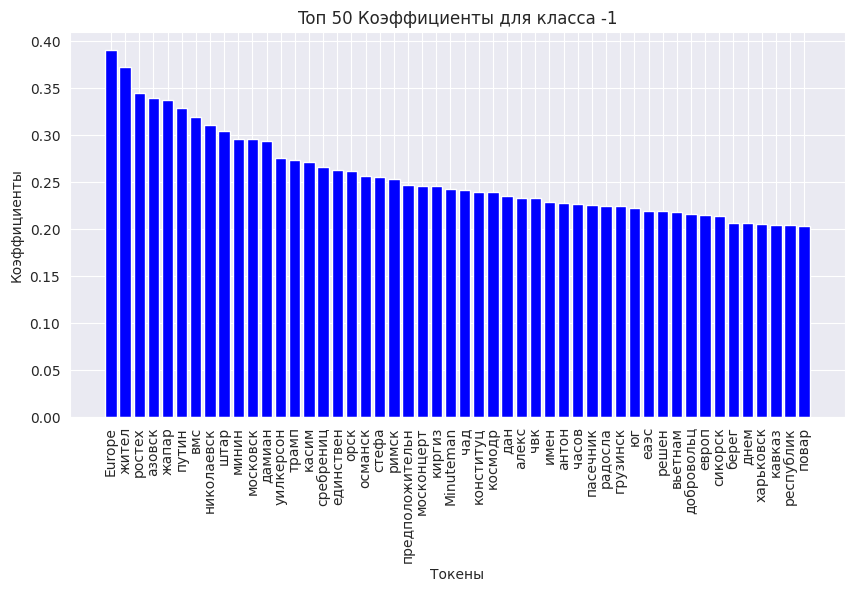

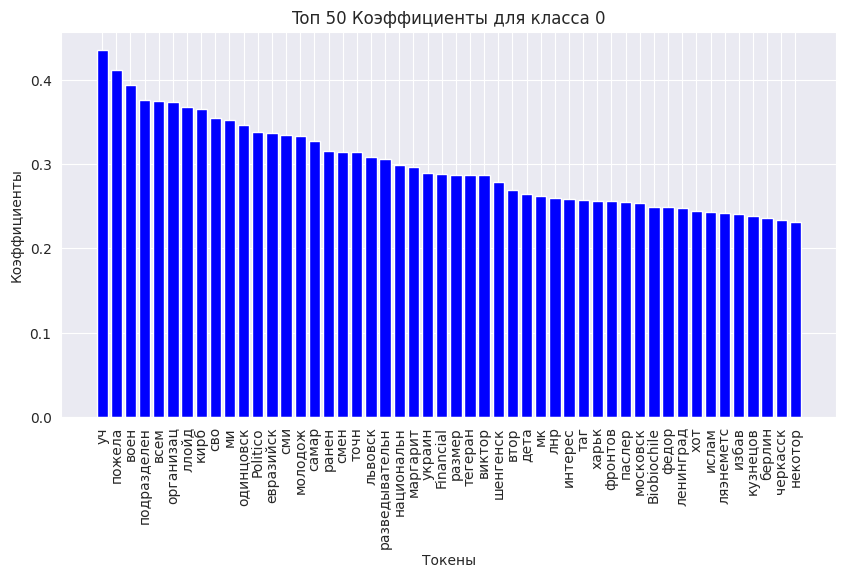

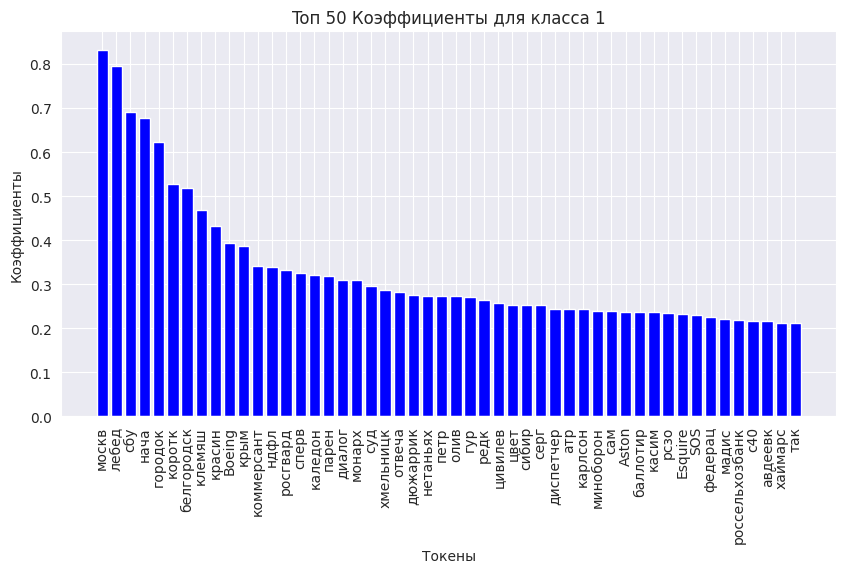

In [37]:
model = pipeline.named_steps['logisticregression']

feature_names = X_train.columns
coefficients = model.coef_

def plot_top_coefficients(class_index, num_features=10):
    coefs = coefficients[class_index]
    top_positive_coefficients = coefs.argsort()[-num_features:][::-1]
    top_coefficients = coefs[top_positive_coefficients]
    top_feature_names = feature_names[top_positive_coefficients]

    plt.figure(figsize=(10, 5))
    plt.bar(top_feature_names, top_coefficients, color='blue')
    plt.xlabel('Токены')
    plt.ylabel('Коэффициенты')
    plt.title(f'Toп {num_features} Коэффициенты для класса {model.classes_[class_index]}')
    plt.xticks(rotation=90)
    plt.show()

for i in range(len(model.classes_)):
    plot_top_coefficients(i, num_features=50)

Как итог, вывод, который я могу сделать, глядя на эти столбчатые диаграммы и на проведенный мною EDA анализ, что основный критерием успешности того или иного поста является его общая тематика, так или иначе завязанная на токенах, которые в нем используются. Чем более токены не связаны с территорией России и с проблемами, волнующими обычных людей, тем больше вероятность того, что пост окажется непопулярным. Это можно увидеть и по диаграмме для класса -1, где половина токенов это названия, связанные с зарубежьем и по EDA анализу. Основная рекомендация тут является простой - если редакция хочет успешные посты, нужно больше обозревать события происходящие сугубо в России, а вот хочет ли этого редакция - другой вопрос... Спасибо за внимание!!!

P.S. Вроде код и текст писал аккуратно, но если где-то были опечатки простите душу грешную...